# CS522 - Final Project
The objective of the final project is to integrate various machine learning techniques to achieve the best performance. Final project is a group effort. Each group can have 4-5 members. You are required to apply ALL techniques learned in this semester.

## Schedule
- (5) Milestone 1 (Due 11/4): Group Formation and Topic selection. Submit through Canvas. Approval and comments will be returned in one day. The same topic cannot be chosen by more than 1 group. The topic follows the first-come first-served rule. So pick a topic as soon as possible.
- (5) Milestone 2 - Literature Survey (Due 11/11): Background study including references and state-of-the-art performance on the dataset (2-page report need to be submitted).
- (5) Milestone 3 - Prototype 1 (Due 11/18): Prototype, preliminary results and task allocation among group members. Apply at least one learned technique successfully for each component in the pipeline on the chosen dataset and submit a 1-page report.
- (5) Milestone 4 - Prototype 2 (Due 12/02): Implement at least two solutions to each component of the pipeline. Determine what metrics to use. Provide performance evaluation results.
- (100) Final presentation (Due 12/08)(Presentation slides due the midnight before the presentation on 12/9. Submit through Canvas)
- (80) Final report (Due 12/10). Submit through Canvas.

## Potential Topics
Each group can choose one topic from the following sources. All selection needs to be approved by instructor.
- KDD-Cup 1997-2009
- Kaggle Competitions
- Other topics: You can select a topic yourself from other resources.

## Requirement
General steps involved in a machine learning problem include
- Data collection (raw data)
- Feature extraction (how to extract features from the raw data)
- Feature selection (dimensionality reduction - Fisher's linear discriminant or PCA)
- Classification/Regression methods need to be included
    - Supervised learning and Unsupervised learning
    - Baysian approaches and non-Baysian approaches
    - Parametric and Non-parametric density estimation in supervised learning
    - Fusion
- Performance evaluation
- Feedback system

You are required to evaluate the effect of various aspects of the classification/regression process, including but not limited to
- the effect of assuming the data is Gaussian-distributed
- the effect of assuming parametric pdf vs. non-parametric pdf
- the effect of using different prior probability ratio
- the effect of using different distance
- the effect of knowing the class label
- the effect of dimension of the feature space (e.g., changed through dimensionality reduction)
- the effect of fusion

To be more specific, you need to at least go through the following steps:
- Data normalization
- Dimensionality reduction
    - Classification/Regression with the following
    - MPP (case 1, 2, and 3)
    - kNN with different k's
    - BPNN
    - Decision tree
    - SVM
    - Clustering (kmeans, wta)
- Classifier fusion
- Evaluation (use n-fold cross validation to generate confusion matrix and ROC curve if applicable).

# 1. Data collection (raw data) - Face Mask 12k Images Dataset
- URL: [https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)

This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.

"All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530). Thank you so much Jessica for providing a wonderful dataset to the community."


In [70]:
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


## 1.1. Read In Data
Throughout this project:
- 0 corresponds to not wearing a mask
- 1 corresponds to wearing a mask

In [42]:
# make directory to save generated images to
os.makedirs('img', exist_ok=True)



dataset_dir = os.path.join("datasets", "face_mask")
def get_dataset_fn(dataset_dir: str, type: str) -> (np.array, np.array):
    """
    given the directory name of the entire dataset and whether it is the train, validation, or test set
    return X and y where X is a list of filenames and y is the target labels
    """
    # get base dir path (account for different operating systems)
    base_dir = os.path.join(dataset_dir, type)
    # get directories for each class in each folder
    no_mask_dir = os.path.join(base_dir, "WithoutMask")
    mask_dir = os.path.join(base_dir, "WithMask")
    # get filenames
    no_mask_fn = list(map(lambda fn: os.path.join(no_mask_dir,fn),os.listdir(no_mask_dir)))
    mask_fn = list(map(lambda fn: os.path.join(mask_dir,fn), os.listdir(mask_dir)))
    # create X with associated y labels
    y = np.hstack((np.zeros(len(no_mask_fn)),np.ones(len(mask_fn))))
    X = np.hstack((np.array(no_mask_fn),np.array(mask_fn)))
    return X, y

def load_img(fn: str) -> np.array:
    """
    load an image into a numpy array from the given filename
    # converts to grayscale
    """
    return np.array(Image.open(fn))
    # return np.array(Image.open(fn).convert('L'))

def load_dataset(X_fn: np.array) -> list:
    """
    given a list of filenames, load in each image into a numpy array and return a list of the images
    """
    X = []
    # iterate through each filename and load in each image
    for i in range(len(X_fn)):
        X.append(load_img(X_fn[i]))

    # returns X as a list because images are different sizes
    return X

def to_categorical(y) -> np.array:
    """
    One hot encode the target labels
    """
    Y = np.zeros((len(y),len(np.unique(y))))
    for i in range(len(y)):
        Y[i,int(y[i])] = 1
    return Y

def show_img(ax, img: np.array, label=None):
    ax.axis("off")
    ax.imshow(img)
    # plt.show()

# get dataset of filenames and labels
X_train_fn, y_train = get_dataset_fn(dataset_dir, "train")
X_validation_fn, y_validation = get_dataset_fn(dataset_dir, "validation")
X_test_fn, y_test = get_dataset_fn(dataset_dir, "test")

# one hot encode target labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_validation = to_categorical(y_validation)

# load in images
X_train = load_dataset(X_train_fn)
X_validation = load_dataset(X_validation_fn)
X_test = load_dataset(X_test_fn)


## 1.2. Normalizing dataset
Need to standardize the size of the images.
It is conventional to resize all of the images to the smallest image in the dataset.
https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction



In [62]:
# resize images
def resize_img(x:np.array, size: tuple):

    return np.asarray(Image.fromarray(x, mode="RGB").resize((size[0],size[1]), resample=PIL.Image.LANCZOS))
def resize_dataset(X, size:tuple):
    X_new = np.zeros((len(X), size[0], size[1], size[2]))
    print(X_new.shape)
    for i, x in enumerate(X):
        X_new[i] = resize_img(x, size)
    return X_new
size = (64,64,3)
X_train_resized = resize_dataset(X_train, size)
X_validation_resized = resize_dataset(X_validation, size)
X_test_resized = resize_dataset(X_test, size)

# min-max scale images
def min_max_scale_img(x:np.array):
    x = x.astype("float64")
    x /= 255
    return x
def min_max_scale_dataset(X):
    X_new = []
    for x in X:
        X_new.append(min_max_scale_img(x))
    return X_new
X_train_norm = min_max_scale_dataset(X_train_resized)
X_validation_norm = min_max_scale_dataset(X_validation_resized)
X_test_norm = min_max_scale_dataset(X_test_resized)


(10000, 64, 64, 3)
(800, 64, 64, 3)
(992, 64, 64, 3)


## 1.3. Peek at Dataset
In order to get a feel for the data, lets look at some of the images

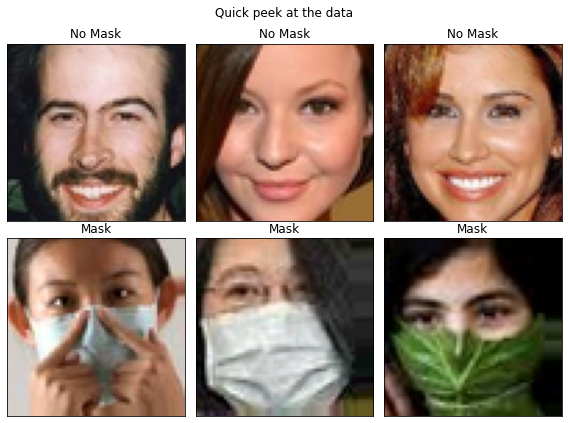

In [63]:
def plot_img_grid(img, label, size, pos):
    """
    given the image, its label, the size of the grid, and its position on the grid,
    create a grid of images displaying images in the dataset
    """
    ax = plt.subplot2grid(size, pos)
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    ax.title.set_text(label)
    ax.imshow(img)

fig = plt.figure(figsize=(8,6))
fig.suptitle('Quick peek at the data')
plot_img_grid(X_train_norm[0], 'No Mask', (2,3),(0,0))
plot_img_grid(X_train_norm[1000], 'No Mask', (2,3),(0,1))
plot_img_grid(X_train_norm[2000], 'No Mask', (2,3),(0,2))
plot_img_grid(X_train_norm[7000], 'Mask', (2,3),(1,0))
plot_img_grid(X_train_norm[8001], 'Mask', (2,3),(1,1))
plot_img_grid(X_train_norm[9004], 'Mask', (2,3),(1,2))
plt.tight_layout()
plt.savefig('./img/faces.png', dpi=500)
plt.show()


# 2. Feature extraction
Objective: how to extract features from the raw data

# 2.1. Convolutional Neural Network (CNN)
Build Layers And Sequential Model For The Convolution


In [77]:
class Layer:
    def __init__(self, name):
        self.name = name
        self.output_shape = (0,0,0)

class Conv2D(Layer):
    def __init__(self, activation="relu", name="conv2d"):
        super().__init__(f'{name} (Conv2D)')
        self.activation = activation

class MaxPooling2D(Layer):
    def __init__(self, shape=(2,2), name="max_pooling2d"):
        super().__init__(f'{name} (MaxPooling2D)')
        self.shape = shape

class Activation(Layer):
    def __init__(self, activation, name="activation"):
        super().__init__(f'{name} (Activation)')
        self.activation = activation

class Flatten(Layer):
    def __init__(self, name="flatten"):
        super().__init__(f'{name} (Flatten)')

class Sequential:
    def __init__(self):
        self.layers = []
    def summary(self):
        print("Model: Sequential")
        print("#    Layer                     Output Shape")
        for i, l in enumerate(self.layers):
            print(f"{i:<4} {l.name:<25} {l.output_shape}")
    def add(self, layer: Layer):
        self.layers.append(layer)
    def compile(self):
        pass

model = Sequential()
model.add(Conv2D(name="input_layer"))
model.add(MaxPooling2D(name="pooling1"))
model.add(Activation('relu'))
model.add(Conv2D(name="layer1"))
model.add(MaxPooling2D(name="pooling2"))
model.add(Flatten(name='flatten'))
model.summary()


Model: Sequential
#    Layer                     Output Shape
0    input_layer (Conv2D)      (0, 0, 0)
1    pooling1 (MaxPooling2D)   (0, 0, 0)
2    activation (Activation)   (0, 0, 0)
3    layer1 (Conv2D)           (0, 0, 0)
4    pooling2 (MaxPooling2D)   (0, 0, 0)
5    flatten (Flatten)         (0, 0, 0)


[[53.82]]
[[126.07]]


array([[ 0.        ],
       [ 2.34243776],
       [ 4.45063174],
       [ 7.02731327],
       [ 9.13550725],
       [11.71218878]])

0.01858045336306206

# 3. Feature Selection
Dimensionality Reduction - Fisher's linear discriminant or PCA

In [ ]:
4.

# 4. Classification/Regression methods need to be included
- Supervised learning and Unsupervised learning
- Baysian approaches and non-Baysian approaches
- Parametric and Non-parametric density estimation in supervised learning
- Fusion

Classification performed with:
1. MPP (case 1, 2, and 3)
2. kNN with different k's
3. BPNN
4. Decision tree
5. SVM
6. Clustering (kmeans, wta)

You are required to evaluate the effect of various aspects of the classification/regression process, including but not limited to:
- the effect of assuming the data is Gaussian-distributed
- the effect of assuming parametric pdf vs. non-parametric pdf
- the effect of using different prior probability ratio
- the effect of using different distance
- the effect of knowing the class label
- the effect of dimension of the feature space (e.g., changed through dimensionality reduction)
- the effect of fusion

# 5. Performance evaluation
Note: Use n-fold cross validation to generate confusion matrix and ROC curve if applicable.

# 6. Feedback system
Maybe